# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [264]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [265]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

Descriptive statistics for user interactions:
count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: count, dtype: float64


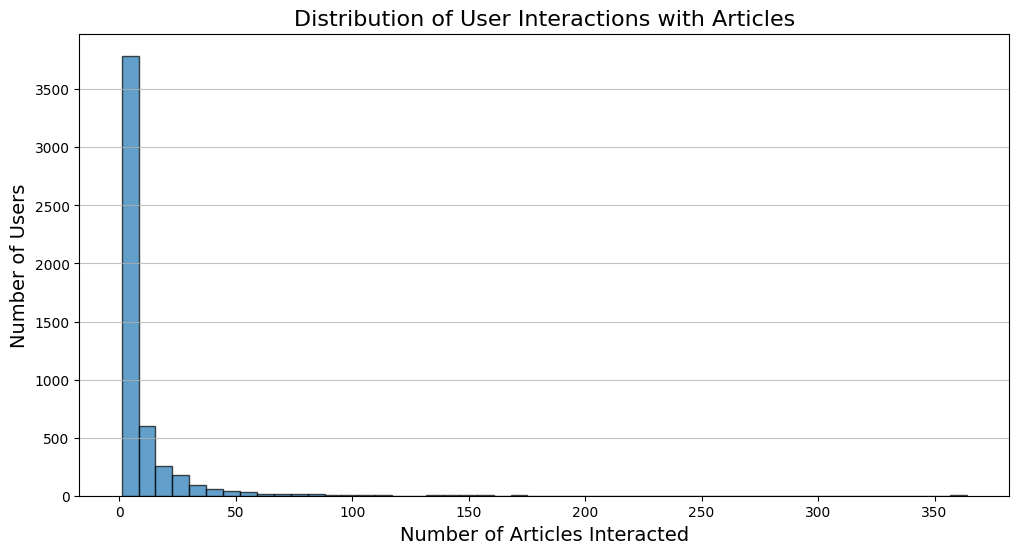

25th percentile: 1.0 interactions
50th percentile: 3.0 interactions
75th percentile: 9.0 interactions
90th percentile: 22.0 interactions


In [266]:
# Calculate the number of articles each user interacts with
user_interactions = df['email'].value_counts()

# Display descriptive statistics
print("Descriptive statistics for user interactions:")
print(user_interactions.describe())

# Plot the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(user_interactions, bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of User Interactions with Articles', fontsize=16)
plt.xlabel('Number of Articles Interacted', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Additional insights
percentiles = [25, 50, 75, 90]
for p in percentiles:
    print(f"{p}th percentile: {user_interactions.quantile(p / 100)} interactions")


In [267]:
# Fill in the median and maximum number of user_article interactions below

# Calculate the median value (50% của người dùng tương tác với số bài viết <= giá trị này)
median_val = user_interactions.median()

# Calculate the maximum number of interactions by any user
max_views_by_user = user_interactions.max()

print(f"Median value: {median_val}")
print(f"Maximum views by a single user: {max_views_by_user}")

Median value: 3.0
Maximum views by a single user: 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [268]:
# Find and explore duplicate articles
duplicate_articles = df_content[df_content.duplicated(subset='article_id')]

print(f"Number of duplicate articles: {duplicate_articles.shape[0]}")
duplicate_articles.head()

Number of duplicate articles: 5


,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [269]:
# Remove any rows that have the same article_id - only keep the first
df_content_cleaned = df_content.drop_duplicates(subset='article_id', keep='first')
print(f"Number of articles after removing duplicates: {df_content_cleaned.shape[0]}")

Number of articles after removing duplicates: 1051


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [270]:
# a. The number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique()

# b. The number of unique articles in the dataset (whether they have any interactions or not)
total_articles = df_content['article_id'].nunique()

# c. The number of unique users in the dataset (excluding null values)
unique_users = df['email'].nunique()

# d. The number of user-article interactions in the dataset
user_article_interactions = df.shape[0]

# Display the results
print(f"Unique articles with at least one interaction: {unique_articles}")
print(f"Total unique articles in the dataset: {total_articles}")
print(f"Unique users: {unique_users}")
print(f"User-article interactions: {user_article_interactions}")


Unique articles with at least one interaction: 714
Total unique articles in the dataset: 1051
Unique users: 5148
User-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [271]:
# Find the most viewed article_id and its view count
most_viewed_article_id = df['article_id'].value_counts().idxmax()  # The article_id with the highest views
max_views = df['article_id'].value_counts().max()  # The number of views for the most viewed article

print(f"The most viewed article_id: {most_viewed_article_id}")
print(f"The most viewed article was viewed {max_views} times")

The most viewed article_id: 1429.0
The most viewed article was viewed 937 times


In [272]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [273]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': str(most_viewed_article_id),
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [274]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles

    """
    # Group by 'article_id' and count interactions
    top_articles_df = df.groupby('article_id').size().sort_values(ascending=False)
    
    # Get the article titles corresponding to the top 'n' article IDs
    top_articles = df[df['article_id'].isin(top_articles_df.index[:n])]['title'].unique().tolist()
    
    return top_articles

def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids

    """
    # Group by 'article_id' and count interactions
    top_article_ids = df['article_id'].value_counts().head(n).index.tolist()
    
    return top_article_ids

In [275]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [276]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [277]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [278]:
def create_user_item_matrix(df):
    """
    INPUT:
    df - pandas dataframe with article_id, title, and user_id columns
    
    OUTPUT:
    user_item - user-item matrix:
                - rows: user IDs
                - columns: article IDs
                - values: 1 (if the user interacted with the article) or 0 (otherwise)
                
    Description:
    This function returns a matrix where each row represents a user, 
    each column represents an article, and the values are binary 
    (1 if the user has interacted with the article, 0 otherwise).
    """
    # Pivot the dataframe to create the user-item matrix
    user_item = df.pivot_table(index='user_id', 
                               columns='article_id', 
                               values='title', 
                               aggfunc='count', 
                               fill_value=0)
    
    # Convert all non-zero values to 1 (binary representation)
    user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)
    
    return user_item
user_item = create_user_item_matrix(df)

C:\Users\CSTra\AppData\Local\Temp\ipykernel_13764\3567218042.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)


In [279]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [280]:
def find_similar_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    similar_users - (list) an ordered list where the closest users 
                    (largest dot product users) are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product.
    Returns an ordered list of users from most similar to least similar.
    """
    # Compute the dot product to measure similarity
    user_vector = user_item.loc[user_id].values
    similarity_scores = user_item.dot(user_vector)
    
    # Create a series for sorting
    similarity_scores = pd.Series(similarity_scores, index=user_item.index)
    
    # Sort the users by similarity score in descending order
    sorted_users = similarity_scores.sort_values(ascending=False)
    
    # Remove the own user's id from the list
    similar_users = sorted_users.index[sorted_users.index != user_id].tolist()
    
    return similar_users


In [281]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [282]:


def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids
                    (this is identified by the title column in df)
    """
    # Retrieve unique article names for the provided article ids
    article_ids = [float(id) for id in article_ids]
    article_names = set(df[df['article_id'].isin(article_ids)]['title'].unique())
    
    return article_names


def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids
                    (this is identified by the title column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    # Get article ids the user has interacted with
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.tolist()
    article_ids = [str(id) for id in article_ids]
    # Get article names for those article ids
    article_names = get_article_names(article_ids, df)
    
    return article_ids, article_names


def user_user_recs(user_id, m=10, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    """
    # Find similar users
    similar_users = find_similar_users(user_id, user_item)
    
    # Get articles the user has seen
    seen_article_ids, _ = get_user_articles(user_id, user_item)
    
    recs = []
    for similar_user in similar_users:
        # Get articles the similar user has seen
        article_ids, _ = get_user_articles(similar_user, user_item)
        
        # Find articles not yet seen by the current user
        new_recs = [article_id for article_id in article_ids if article_id not in seen_article_ids]
        
        # Add to recommendations until we reach m
        recs.extend(new_recs)
        if len(recs) >= m:
            break
    
    # Return only m recommendations
    return recs[:m]


In [283]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

{'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'graph-based machine learning',
 'higher-order logistic regression for large datasets',
 'the 3 kinds of context: machine learning and the art of the frame',
 'this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'using brunel in ipython/jupyter notebooks',
 'using machine learning to predict parking difficulty'}

In [284]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [285]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user_id
    df - (pandas dataframe) df as defined at the top of the notebook
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a
    
    Other Details - sort the neighbors_df by:
                    - similarity
                    - num_interactions where highest of each is higher in the dataframe
    """

    # Compute similarity using dot product
    user_vector = user_item.loc[user_id].values
    similarity = user_item.dot(user_vector)

    # Create a dataframe of neighbors
    neighbors_df = pd.DataFrame({
        'neighbor_id': user_item.index,
        'similarity': similarity
    })

    # Remove the current user from the neighbors
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]

    # Add interactions to neighbors
    user_id_interactions = df['user_id'].value_counts()
    interactions = [user_id_interactions[id] for id in neighbors_df.index]
    neighbors_df['interactions'] = interactions
    neighbors_df.sort_values(by=['similarity', 'interactions'], ascending=False, inplace=True)
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title

    Description:
    Loops through the users based on closeness to the input user_id.
    For each user - finds articles the user hasn't seen before and provides them as recommendations.
    Does this until m recommendations are found.
    Recommendations are sorted based on the interaction count of articles.
    """
    # Get user articles
    user_article_ids, _ = get_user_articles(user_id)

    # Get similar users
    most_similar_users = get_top_sorted_users(user_id, user_item=user_item)

    # Initialize recommendations
    recs = []

    # Grouping articles by interaction count
    article_interactions = df['article_id'].value_counts()

    # Loop through similar users to gather recommendations
    for _, neighbor in most_similar_users.iterrows():
        # Articles seen by the neighbor
        neighbor_articles, _ = get_user_articles(neighbor['neighbor_id'])
        
        # Articles not seen by the current user
        new_recs = np.setdiff1d(neighbor_articles, user_article_ids, assume_unique=True)
        
        # Sort recommendations based on article popularity/interaction count
        recs_to_add = article_interactions.loc[new_recs.astype(float)].sort_values(ascending=False)
        
        # Append recommendations
        recs.extend(recs_to_add.keys())
        
        # Break the loop if enough recommendations are gathered
        if len(recs) >= m:
            break

    # Return the top m recommendations
    recs = recs[:m]
    rec_names = get_article_names(recs)
    
    return recs, rec_names


In [286]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
{'apache spark lab, part 1: basic concepts', 'movie recommender system with spark machine learning', 'putting a human face on machine learning', 'analyze accident reports on amazon emr spark', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'predicting churn with the spss random tree algorithm', 'insights from new york car accident reports', 'model bike sharing data with spss'}


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [287]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1
user1_most_sim = get_top_sorted_users(1, user_item=user_item).iloc[0]['neighbor_id']

# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131, user_item=user_item).iloc[9]['neighbor_id']

In [288]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

##### Answer:

1. **Functions that can be used:**
   - For a new user, the **`get_top_articles`** function can be used to make recommendations.
   - Reason: Since the new user has no interaction history, functions like **`user_user_recs`** or **`get_top_sorted_users`** cannot be used, as they rely on comparing the user's behavior to other similar users.

2. **Current approach:**
   - The **`get_top_articles`** function selects the most popular articles (based on the total number of interactions) to recommend to the new user. This is a reasonable approach when there is no personalized information available.

---

**Can you think of a better way to make recommendations for new users?**

##### Suggested Improvements:

1. **Content-Based Filtering:**
   - Use article features (e.g., topics, keywords, categories) to recommend the most relevant articles based on the user's potential interests.
   - Combine this with basic user information (if available), such as:
     - Preferences, profession, or geographic location.
     
2. **Initial Survey:**
   - Ask the user what they are interested in and provide recommendations based on their answers.




`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [289]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)
new_user_recs = [str(id) for id in new_user_recs]

In [290]:
print(new_user_recs)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [291]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [292]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [293]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [294]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False)

**We can perform the SVD operation here because there are no missing values in the matrix. If there were missing values, SVD would not work directly. In our case, since the matrix is binary (0/1), it simplifies the problem. For a 'rating' matrix with continuous values, replacing NaNs with 0 arbitrarily could introduce bias, but in this binary case, it is a natural assumption. Therefore, SVD works perfectly for this dataset.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

c:\Users\CSTra\anaconda3\envs\MLBasic\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


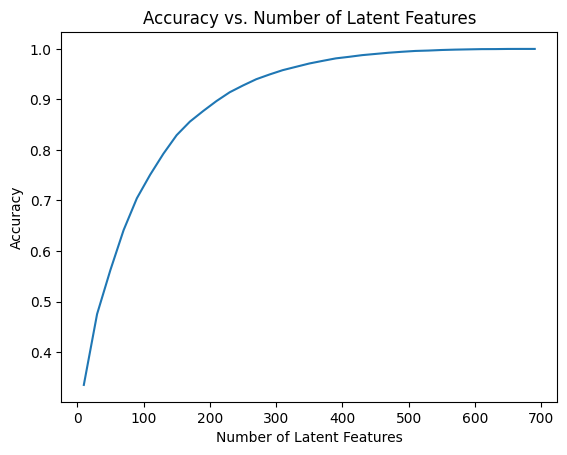

In [295]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [296]:
df

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5
...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,5146
45989,142.0,neural networks for beginners: popular types a...,5146
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148


In [297]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    """
    INPUT:
    df_train - training dataframe
    df_test - test dataframe

    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe
                     (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    """
    # Create user-item matrices for train and test sets
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # Extract unique user ids and article ids for the test set
    test_idx = np.unique(df_test['user_id'])
    test_arts = np.unique(df_test['article_id'])

    return user_item_train, user_item_test, test_idx, test_arts



user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)


C:\Users\CSTra\AppData\Local\Temp\ipykernel_13764\3567218042.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)
C:\Users\CSTra\AppData\Local\Temp\ipykernel_13764\3567218042.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)


In [298]:
# Calculate the answers for the four questions
# Question 1: How many users can we make predictions for in the test set?
a = len(set(user_item_test.index) & set(user_item_train.index))

# Question 2: How many users in the test set are we not able to make predictions for because of the cold start problem?
b = len(set(user_item_test.index) - set(user_item_train.index))

# Question 3: How many articles can we make predictions for in the test set?
c = len(set(user_item_test.columns) & set(user_item_train.columns))

# Question 4: How many articles in the test set are we not able to make predictions for because of the cold start problem?
d = len(set(user_item_test.columns) - set(user_item_train.columns))

a, b, c, d

(20, 662, 574, 0)

In [299]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [300]:
# Perform SVD on the training dataset
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)

In [301]:
# Perform SVD on the training dataset
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)

# Find common users and articles between train and test
common_users = user_item_train.index[user_item_train.index.isin(test_idx)]
common_articles = user_item_train.columns[user_item_train.columns.isin(test_arts)]

# Subset matrices for common users and articles
train_rows = user_item_train.index.isin(common_users)
test_rows = user_item_test.index.isin(common_users)
train_cols = user_item_train.columns.isin(common_articles)

In [325]:

# Set up latent feature ranges and storage for error and accuracy
num_latent_features = np.arange(10, 700 + 10, 20)
train_errors = []
test_errors = []
train_accuracies = []
test_accuracies = []

# Loop over latent feature range
for k in num_latent_features:
    # Reconstruct using k latent features
    s_k = np.diag(s_train[:k])
    u_k = u_train[:, :k]
    vt_k = vt_train[:k, :]
    
    train_pred = np.around(np.dot(np.dot(u_k, s_k), vt_k))
    
    # Subset predictions and actual data for common users/articles
    train_subset = user_item_train.to_numpy()[train_rows][:, train_cols]
    # print(train_subset)
    train_pred_subset = train_pred[train_rows][:, train_cols]
    
    test_subset = user_item_test.to_numpy()[test_rows, :]
    test_pred_subset = train_pred[train_rows, :][:, train_cols]

    # Calculate errors
    train_error = np.sum(np.abs(np.subtract(train_subset, train_pred_subset)))
    test_error = np.sum(np.abs(np.subtract(test_subset, test_pred_subset)))

    # Calculate accuracy
    # Accurary
    train_accuracies.append(accuracy_score(train_subset.flatten(), train_pred_subset.flatten()))
    test_accuracies.append(accuracy_score(test_subset.flatten(), test_pred_subset.flatten()))
    
    train_errors.append(train_error)
    test_errors.append(test_error)


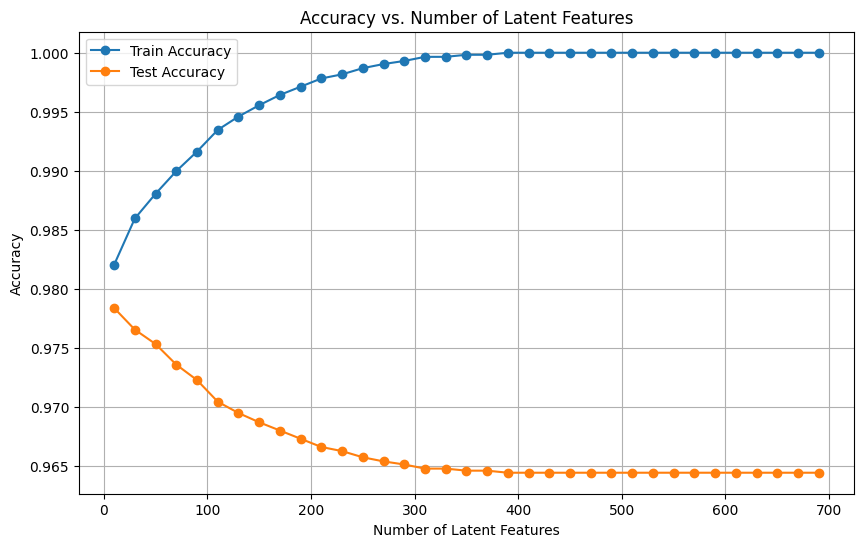

In [326]:

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(num_latent_features, train_accuracies, label='Train Accuracy', marker='o')
ax.plot(num_latent_features, test_accuracies, label='Test Accuracy', marker='o')
ax.set_xlabel('Number of Latent Features')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs. Number of Latent Features')
ax.grid(True)
ax.legend()
plt.show()


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

### Analysis and Practical Evaluation Plan for the Recommendation System

Based on the graph, the recommendation system demonstrates high accuracy on the training set as the number of latent features increases. However, the performance on the test set gradually decreases with an increasing number of latent features, indicating potential overfitting. This is likely due to the imbalanced nature of the dataset, where negative interactions dominate positive ones. To address this, methods such as SMOTE for synthetic oversampling or reweighting classes during training could be applied.

### Proposed Method to Evaluate the Recommendation System in Practice

To properly evaluate the recommendation system's performance in a real-world scenario, the following experimental setup is proposed:

1. **Define Evaluation Metrics**:
   - Use standard recommendation system metrics such as Precision, Recall, F1-score, and Mean Average Precision (MAP) to measure the system's effectiveness.
   - Consider metrics that reflect user engagement and satisfaction, like click-through rate (CTR) or time spent on recommended content.

2. **Set Up Control Groups**:
   - Divide the user base into groups where one uses the recommendation system (treatment group) and the other does not (control group). This setup allows for a comparison of the system's impact on user behavior.

3. **Implement A/B Testing**:
   - Use A/B testing or randomized controlled trials to validate the effectiveness of the recommendation system.
   - Randomly assign users to different configurations of the recommendation system to test variations (e.g., different numbers of latent features or algorithms).

4. **Address Class Imbalance Challenges**:
   - Mitigate the effects of class imbalance using oversampling (e.g., SMOTE) for underrepresented interactions or assigning higher weights to minority classes during training.
   - Monitor the distribution of recommended versus non-recommended items to ensure balanced outputs.

5. **Analyze User Feedback**:
   - Collect qualitative and quantitative user feedback on the recommendations to understand satisfaction levels and identify improvement opportunities.

### Practical Challenges and Mitigation Strategies

- **Class Imbalance**:
  - Heavily imbalanced datasets may skew the recommendations towards popular items. Address this by using resampling techniques or adjusting class weights.
- **Scalability**:
  - As the user base grows, ensure the recommendation system can scale effectively by optimizing the computational complexity of matrix factorization and leveraging distributed computing frameworks.
- **Evaluation Bias**:
  - Minimize evaluation bias by ensuring diverse user demographics are represented in the experiment.

### Conclusion

This plan provides a structured approach to evaluate the recommendation system's performance both quantitatively and qualitatively. By combining robust experimental design, practical considerations, and targeted strategies for addressing challenges, the system can be refined to deliver more accurate and user-friendly recommendations.


<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [85]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1